In [1]:
"""
Learning to solve parametric Quadratic Programming
portfolio optimization
problems using Neuromancer.

Problem formulation:
    minimize    - p^T x + lambda x^T Q x
    subject to       1^T x = 1
                      x >= 0

Where p is interpreted as a vector of asset returns, and Q represents
the covariance between assets, which forms a penalty on overall
covariance (risk) weighted by lambda.
"""

'\nLearning to solve parametric Quadratic Programming\nportfolio optimization\nproblems using Neuromancer.\n\nProblem formulation:\n    minimize    - p^T x + lambda x^T Q x\n    subject to       1^T x = 1\n                      x >= 0\n\nWhere p is interpreted as a vector of asset returns, and Q represents\nthe covariance between assets, which forms a penalty on overall\ncovariance (risk) weighted by lambda.\n'

In [2]:

import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

from portfolio_utils import gen_portfolio_lto_data, cvx_qp
import cvxpy as cp
from cvxpylayers.torch.cvxpylayer import CvxpyLayer


In [3]:

""
"""
# # #  Dataset
"""
data_seed = 408
np.random.seed(data_seed)
batsize = 100
n_dim = 100
n_train = 300
n_valid = 100
n_test = 100

budget = 10


#nsim = 100  # number of datapoints: increase sample density for more robust results

# create dictionaries with sampled datapoints with uniform distribution
#data_loaded = np.load('portfolio_data/portfolio_var50_ineq50_eq1_ex12000.npz', allow_pickle=True)
data_loaded = gen_portfolio_lto_data(n_dim,n_train,n_valid,n_test)
Q_load = data_loaded['Q']
A_load = data_loaded['A']
G_load = data_loaded['G']
h_load = data_loaded['h']
x_load = data_loaded['x']
p_train = data_loaded['trainX']
p_valid = data_loaded['validX']
p_test  = data_loaded['testX']
sols_train = data_loaded['trainY']
sols_valid = data_loaded['validY']
sols_test  = data_loaded['testY']
#feat_size_load = data_loaded['feat_size']

print("p_train.dtype")
print( p_train.dtype )

samples_train = {"p": torch.Tensor(p_train)}  # JK TODO fix this, reduced size for debugging
samples_dev   = {"p": torch.Tensor(p_valid)}
samples_test  = {"p": torch.Tensor(p_test )}

# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data   = DictDataset(samples_dev,   name='dev')
test_data  = DictDataset(samples_test,  name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batsize, num_workers=0,
                                            collate_fn=train_data.collate_fn, shuffle=True)
dev_loader   = torch.utils.data.DataLoader(dev_data, batch_size=batsize, num_workers=0,
                                            collate_fn=dev_data.collate_fn, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batsize, num_workers=0,
                                            collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle


""

"""
# # #  pQP primal solution map architecture
"""
# define neural architecture for the solution map
func = blocks.MLP(insize=n_dim, outsize=n_dim,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[n_dim*2] * 4)
# define symbolic solution map with concatenated features (problem parameters)
#xi = lambda p1, p2: torch.cat([p1, p2], dim=-1)
#features = Node(xi, ['p1', 'p2'], ['xi'], name='features')
sol_map = Node(func, ['p'], ['x'], name='map')
# trainable components of the problem solution
components = [sol_map]




"""
# # # objective and constraints formulation in Neuromancer
"""
# variables
x = variable("x")

# sampled parameters
p = variable('p')
Q = torch.Tensor(Q_load)

# objective function
lambd = 1.0
f = torch.sum(-p*x, dim = 1) + torch.sum( x*torch.matmul(Q,x.T).T, dim=1 ) #-p@x + lambd * x@Q@x
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]

# constraints
e = torch.ones(n_dim)
Q_con = 100.
con_1 = Q_con*(torch.sum(x, dim=1) == 1) #Q_con*(e@x == 1)
con_1.name = 'c1'
con_2 = Q_con * (x >= 0)
con_2.name = 'c2'

constraints = [con_1, con_2]






"""
# # #  problem formulation in Neuromancer
"""
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)




Generating dataset . . . 
[ 2.58620561e-02 -1.85621060e-03 -1.34750445e-03 -1.80741762e-03
 -1.82372647e-03 -1.27234544e-03 -1.52829587e-03 -8.75392205e-04
 -1.54689109e-03 -1.55905886e-03 -1.14807011e-03  1.65870391e-01
  6.91374269e-02 -1.40959009e-03 -9.55977755e-04 -1.60035961e-03
  1.09725219e-01 -1.82803949e-03 -1.85824479e-03 -1.71164249e-03
 -1.82879973e-03  1.80966893e-02 -1.81015670e-03 -1.77182656e-03
 -1.57557332e-03  7.32330034e-02  9.95786963e-02 -1.01428045e-03
 -1.87179768e-03 -1.71060412e-03 -1.81435530e-03 -1.83394680e-03
  4.56317210e-02 -1.81676910e-03 -1.85142558e-03 -1.53577815e-03
 -1.53808102e-03 -1.78413652e-03 -1.65895490e-03 -1.62429619e-03
  9.02737226e-02  3.76810788e-02 -1.69956989e-03 -1.68223439e-03
 -1.83617801e-03 -1.54330943e-03 -1.86868891e-03 -4.97861012e-04
 -1.26548332e-03  5.87872053e-05  5.16736672e-03 -1.78113984e-03
 -1.54028178e-03 -1.17208728e-03  1.57322222e-01 -1.83749017e-03
 -1.84170656e-03 -1.84940796e-03 -1.54162146e-03 -1.82261819e-03

/Users/king339/anaconda3/envs/DOPX_layers/lib/python3.9/site-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
/Users/king339/Projects/DAIDIST/neuromancer/src/neuromancer/constraint.py:160: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


epoch: 0  train_loss: 56.39088821411133
epoch: 1  train_loss: 63.36844253540039
epoch: 2  train_loss: 23.48932456970215
epoch: 3  train_loss: 36.163028717041016
epoch: 4  train_loss: 14.16210651397705
epoch: 5  train_loss: 30.33902931213379
epoch: 6  train_loss: 13.31970500946045
epoch: 7  train_loss: 20.011281967163086
epoch: 8  train_loss: 22.089548110961914
epoch: 9  train_loss: 8.708949089050293
epoch: 10  train_loss: 18.563600540161133
epoch: 11  train_loss: 11.391498565673828
epoch: 12  train_loss: 10.7723970413208
epoch: 13  train_loss: 10.939445495605469
epoch: 14  train_loss: 4.4645819664001465
epoch: 15  train_loss: 4.047153949737549
epoch: 16  train_loss: 3.782294511795044
epoch: 17  train_loss: 4.347194194793701
epoch: 18  train_loss: 3.4077234268188477
epoch: 19  train_loss: 2.673877000808716
epoch: 20  train_loss: 3.79227614402771
epoch: 21  train_loss: 4.288987636566162
epoch: 22  train_loss: 3.2208287715911865
epoch: 23  train_loss: 3.1068363189697266
epoch: 24  train_l

In [ ]:

"""
# # #  problem solution in Neuromancer
"""
optimizer = torch.optim.AdamW(problem.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=500,
    patience=100,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

# Train solution map
best_model = trainer.train()



In [21]:
'''
This Cell Computes a Heuristic Metric Choice For ADMM For this QP problem
following


https://web.stanford.edu/~boyd/papers/pdf/metric_select_DR_ADMM.pdf
https://web.stanford.edu/~boyd/papers/pdf/metric_select_fdfbs.pdf


'''




# Import packages.
import cvxpy as cp
import numpy as np
from scipy.linalg import ldl,eigh,eigh_tridiagonal, null_space

#We start here by defining our QP problem
#Objective
Qm = Q.detach().numpy().copy()




# DEFINE THE CONSTRAINTS
# sum(x) = 1

LX_eq = np.ones((1,n_dim))


L = LX_eq


# LX = np.array([[-1, -1],
#      [1, 1],
#      [1,-1],
#      [-1,1]])
# LS = np.eye(4)
# L = np.concatenate((LX,LS),axis=1)


n_cnstr = 1

### Find the Hessian of d1
#define objective including slack vars
#QXS = np.concatenate((Q,np.zeros((,n_dim))),axis = 1)
#QXS = np.concatenate((QXS,np.zeros((n_dim,2*n_dim))),axis = 0)

QXS = Qm

QL = np.concatenate((QXS,np.transpose(L)),axis = 1) 
LO = np.concatenate((L,np.zeros((L.shape[0],L.shape[0]))),axis = 1)
QL = np.concatenate((QL,LO),axis=0)

P = np.linalg.inv(QL)
P11 = P[0:n_dim,0:n_dim]
e, V = eigh(P11)
R_T = np.matmul(V,np.diag(np.sqrt(np.maximum(e,0))))
R = np.transpose(R_T)
# then we have R_T R = P11

Id = np.eye(n_dim)
M = cp.Variable((n_dim,n_dim),symmetric = True)
t = cp.Variable()
obj = cp.Minimize(-t)

constraints = [M >>0]
constraints += [ R@M@R_T << Id]
constraints += [ R@M@R_T >> t*Id]
prob = cp.Problem(obj,constraints)
prob.solve()

Pm = M.value

import scipy.linalg as lg
U,s,V = lg.svd(Pm)
E = np.matmul(U,np.matmul(np.diag(np.sqrt(s)),np.transpose(U)))


#compute gamma heuristic
ye, yV = eigh(np.matmul(E,np.matmul(P11,E)))
zero_thresh = 1e-10 # will consider anything below this threshold zero
ye_notZero = ye[ye>zero_thresh]
gamma = 1/(np.sqrt(np.max(ye_notZero)*np.min(ye_notZero)))



### Check that Q is strongly convex on Null Space of L
NL = null_space(L)
Q_NL = np.matmul(np.transpose(NL),np.matmul(QXS,NL)) 
qnl_eigs = eigh(Q_NL)

In [4]:


'''
#######################################
#######################################

Add on ADMM correction layer

#######################################
########################################
'''


import ADMM as am
from importlib import reload

reload(am)


'''
# DEFINE THE OBJECTIVE
'''
# x is assumed to include slack variables!
def f_obj(x,p):
    x = x[:n_dim]
    return -p@x + lambd * x@(Q@x)            #lambd * torch.sum(x*torch.mv(Q,x))   #torch.sum( -p*x  ) +          #-p@x + lambd * x@(Q@x)


'''
# DEFINE THE CONSTRAINTS
'''
def F_ineq(x,p):
    x = x[:n_dim]
    return -x

def F_eq(x,p):
    x = x[:n_dim]
    return (x.sum() - budget).unsqueeze(0)



num_steps = 10 # number of ADMM iterations to take
x_dim = n_dim # dimension of primal variable
n_ineq = n_dim #number of inequality constraints
n_eq = 1
parm_dim = n_dim #number of problem parameters

#opt_met = am.OptMetric(x_dim,parm_dim,E)

solver = am.ADMMSolver(
    f_obj = f_obj, 
    #F_ineq = F_ineq,
    F_eq = F_eq,
    x_dim = x_dim, 
    #n_ineq = n_ineq,
    n_eq = n_eq, 
    JF_fixed=True,
    parm_dim = parm_dim,
    num_steps = num_steps
    #Metric = opt_met,
    #gamma = gamma
    )

# REMAP THROUGH CORRECTION
sol_map = Node(func, ['p'], ['x_predicted'], name='map')
ADMM_correction = Node(solver,['x_predicted','p'],['x'])
components = [sol_map, ADMM_correction]

objectives = []
constraints = []
# create loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)





In [15]:
solver.num_steps =10

In [6]:

t = time.time()
with torch.no_grad():
    samples_test['name'] = 'test'
    model_out = problem(samples_test)
nm_time = time.time() - t


x_nm_test = model_out['test_' + "x"].detach().numpy()
x_loaded_test  = data_loaded['testY']

print("samples_test['p']")
print(samples_test['p'])

cvxpy_layer = cvx_qp(n_dim,Q,budget)
t = time.time()
x_cvxpy_test = cvxpy_layer(samples_test['p'])
cv_time = time.time() -t

# print("x_nm_test")
# print( x_nm_test )
# print("x_loaded_test")
# print( x_loaded_test )
# print("x_cvxpy_test")
# print( x_cvxpy_test )


print('cv/nm time:',cv_time/nm_time)

sol_diff = np.mean(np.sum((x_cvxpy_test.detach().numpy() - x_nm_test)**2,axis=-1))
print("Average Solution Difference:",np.mean(sol_diff))




# '''
# Compute Train set error
# '''


# with torch.no_grad():
#     t = time.time()
#     samples_train['name'] = 'train'
#     model_out = problem(samples_train)
#     nm_time = time.time() - t


# x_nm_test = model_out['train_' + "x"].detach().numpy()
# x_loaded_test  = data_loaded['trainY']


# cvxpy_layer = cvx_qp(n_dim,Q)
# x_cvxpy_test = cvxpy_layer(samples_train['p'])

# # print("x_nm_test")
# # print( x_nm_test )
# # print("x_loaded_test")
# # print( x_loaded_test )
# # print("x_cvxpy_test")
# # print( x_cvxpy_test )

# sol_diff = np.mean(np.sum((x_cvxpy_test.detach().numpy() - x_nm_test)**2,axis=-1))
# print("Average Solution Difference:",np.mean(sol_diff))




samples_test['p']
tensor([[ 0.1786, -0.2750,  0.2572,  ...,  0.1109, -0.1065, -0.2594],
        [-0.0342,  0.0599, -0.2224,  ...,  0.1452,  0.1426, -0.0713],
        [-0.2396, -0.2704,  0.4451,  ...,  0.0363, -0.3210, -0.1193],
        ...,
        [-0.3598, -0.0125, -0.5187,  ..., -0.1116,  0.1519,  0.1368],
        [ 0.1891,  0.4338,  0.2863,  ..., -0.1248, -0.0170, -0.0291],
        [-0.1225,  0.1041,  0.4266,  ...,  0.1227,  0.3228, -0.3792]])
cv/nm time: 1.8217679306007757
Average Solution Difference: 0.046124


In [5]:
'''
Convergence Evaluation
'''
solver.num_steps = 30


'''
20 Dim eval
'''
# test_p = torch.tensor([ 0.0786, -0.1396,  0.0544,  0.5873, -0.1937,  0.0593,  0.2089, -0.2672,
#          0.2413,  0.1833, -0.1695,  0.1558,  0.3340,  0.2615, -0.0777, -0.2420,
#         -0.4748, -0.0198,  0.0820, -0.1486],dtype = torch.float32)

# test_x = torch.tensor([0.0571, 0.0828, 0.1068, 0.0153, 0.0139, 0.0655, 0.0151, 0.0279, 0.0574,
#         0.0053, 0.0264, 0.0175, 0.0355, 0.0876, 0.0247, 0.0498, 0.0314, 0.0840,
#         0.0746, 0.1085],dtype = torch.float32)





'''
100 Dim eval
'''

test_p =torch.tensor([ 1.7857e-01, -2.7497e-01,  2.5717e-01,  3.8364e-02, -7.7331e-04,
        -2.9028e-01,  3.3549e-02, -1.1741e-01, -2.1641e-02, -3.5141e-02,
         7.9165e-02, -5.1123e-01,  4.4745e-01,  3.6999e-01,  3.5046e-02,
         2.5234e-01,  2.3587e-01,  7.4071e-02, -2.3285e-01,  1.9717e-01,
        -9.9756e-02,  1.3691e-01,  1.6738e-01, -2.2785e-01,  4.0373e-02,
         5.2640e-03,  4.6145e-01, -8.4815e-01,  1.6224e-03, -4.8091e-01,
        -1.0678e-01,  1.6898e-01,  3.6447e-01,  4.2021e-01,  1.3222e-01,
        -1.3869e-01,  2.1727e-01, -2.9587e-01,  1.4124e-01,  3.8298e-01,
         1.3537e-01,  4.8293e-01, -3.2068e-01, -2.2352e-01, -2.5423e-01,
         8.5373e-02, -6.7962e-02, -9.7984e-02, -5.3502e-02,  2.7891e-01,
         2.8244e-01, -1.3083e-01,  7.4079e-02, -4.5340e-01, -3.0208e-01,
        -6.0530e-01,  3.0580e-01,  3.5115e-02, -5.4756e-01, -1.1652e-01,
         2.7381e-01,  4.9779e-01,  3.9558e-01,  1.3829e-01, -5.0766e-01,
         1.6634e-01, -2.1521e-02,  3.3210e-01,  1.8912e-02,  2.3219e-02,
        -5.5921e-01, -1.7104e-01, -2.2898e-01, -2.1905e-01, -1.8726e-01,
        -7.9069e-02, -3.5976e-02,  5.2348e-01, -4.7270e-02,  1.5996e-01,
        -3.7088e-01, -1.5538e-01, -2.1970e-01, -8.4674e-02, -9.5221e-02,
         3.5431e-01,  9.1328e-03,  1.5133e-01,  3.2873e-01, -1.3085e-02,
         2.6877e-01, -6.6001e-02, -1.6084e-02,  2.0000e-01, -9.7725e-02,
        -6.0260e-02,  7.6604e-02,  1.1087e-01, -1.0653e-01, -2.5936e-01],dtype = torch.float32)

test_x = torch.tensor([ 2.8652e-02, -1.8720e-02,  4.5943e-03,  2.0666e-02,  5.3052e-02,
         1.0566e-02, -2.3301e-04,  7.4269e-03, -4.0737e-03,  4.0351e-02,
         3.3887e-03, -2.8895e-02, -8.0340e-03,  5.5137e-02,  2.0804e-02,
         5.8592e-03, -9.7132e-05,  4.8359e-02, -3.4225e-02, -2.6139e-02,
         2.7030e-02, -2.8122e-02, -1.9087e-02,  1.0089e-04,  2.0335e-02,
         5.0663e-03, -1.5315e-02, -1.1443e-02,  4.8434e-02, -9.4290e-03,
        -3.4455e-03,  1.2143e-02, -3.3611e-03,  2.4777e-04,  5.6196e-03,
        -1.0082e-02,  6.5460e-02,  7.1221e-05, -2.5061e-02,  5.1259e-02,
         1.0274e-04,  5.6792e-02,  5.8215e-02, -1.1410e-03,  3.6398e-02,
         1.1078e-02,  4.5247e-02,  1.8908e-02,  2.3678e-03,  3.5135e-03,
         4.1801e-02, -4.6820e-03,  6.3582e-04,  1.6950e-02, -1.3386e-02,
         1.8284e-02, -2.0947e-02,  3.6561e-02,  6.6216e-02, -8.3138e-04,
         7.6932e-05, -7.4624e-03, -1.5951e-02,  1.4933e-02, -3.3135e-02,
         1.6421e-02,  4.4886e-02,  4.2690e-02,  4.6706e-03, -6.9701e-03,
        -1.9117e-02, -4.8848e-04, -3.0347e-02,  1.7936e-02, -2.6791e-04,
         5.1786e-02, -6.4215e-04,  3.8023e-03,  4.3435e-02, -7.2335e-03,
         9.9769e-05,  1.1077e-02,  4.4773e-02,  1.0966e-02, -1.7365e-03,
        -9.9912e-03,  8.1190e-03, -2.1046e-04,  4.0432e-02,  1.9598e-02,
        -1.6820e-02, -1.0310e-02,  4.5409e-02,  5.8548e-03, -1.7351e-02,
        -2.0528e-02, -1.2997e-02,  6.0960e-03,  3.6543e-02,  3.6034e-02],dtype = torch.float32)






'''
pQp Eval
'''

# #test_p = torch.tensor([p1,p2],dtype=torch.float32)
# #test_x = torch.tensor([0.32,-0.37],dtype=torch.float32)
# cvxpy_layer = cvx_qp(n_dim,Q,budget)
# x_cvxpy_test = cvxpy_layer(test_p)




test_x = torch.unsqueeze(test_x,0)
test_p = torch.unsqueeze(test_p,0)

x_hist = solver(test_x,test_p)[3]
x_hist = torch.stack(x_hist).detach().numpy()
x_hist = x_hist[:,0,0:100]


In [ ]:

#np.save('Convergence_Data/portfolio100_ADMM_noSlacks.npy',x_hist)

In [10]:
x_cvxpy_test.detach().numpy()

array([[ 3.66545618e-01, -2.75455075e-10, -1.22103128e-09, ...,
         1.48030326e-01,  9.20662582e-02,  7.25785494e-02],
       [ 3.71445417e-01, -3.51591756e-10, -1.50972701e-09, ...,
         1.52125120e-01,  1.50803089e-01,  1.18620925e-01],
       [ 3.47649544e-01, -7.73862530e-10, -2.58403721e-09, ...,
         1.35170043e-01,  4.70217057e-02,  1.18382797e-01],
       ...,
       [ 2.92746931e-01, -2.08853823e-10, -7.23179183e-10, ...,
         8.28904882e-02,  1.51137516e-01,  1.66426748e-01],
       [ 3.83498430e-01,  9.96434316e-02, -1.42698273e-05, ...,
         9.07161906e-02,  1.19552985e-01,  1.35507926e-01],
       [ 3.61212105e-01,  5.79765020e-03, -1.16917398e-09, ...,
         1.63185045e-01,  2.16789097e-01,  6.23359419e-02]], dtype=float32)

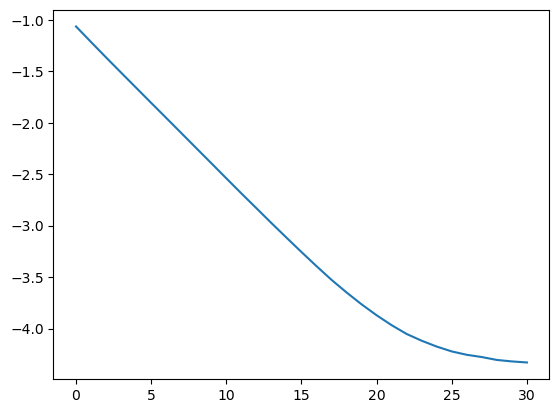

In [18]:
plt.plot(np.log10(np.sum((x_hist - x_cvxpy_test.detach().numpy())**2,axis = 1)))